In [1]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

June 11, 2024 00:14:34


In [2]:
# CCLE_GeneExpression_TPM_v01
# Alberto Bejarano 2024

In [3]:
import warnings; warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
#        -         -        -        -         -        -         -        -        -         -
import pandas as pd
pd.set_option('display.precision',   2)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width',       1000)
pd.options.display.float_format = '{:.3f}'.format
#        -         -        -        -         -        -         -        -        -         -
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns
import numpy as np
import mmap
import os

In [4]:
TissuesOfInterest = ['THYROID', 'BONE', 'ENDOMETRIUM', 'FIBROBLAST', 'KIDNEY', 'PANCREAS', 'BILIARY_TRACT', 'URINARY_TRACT', 'SMALL_INTESTINE', 'PROSTATE',
                     'SALIVARY_GLAND', 'CENTRAL_NERVOUS_SYSTEM', 'LARGE_INTESTINE', 'SKIN', 'LIVER', 'PLEURA', 'CERVIX', 'STOMACH', 'LUNG', 
                     'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'AUTONOMIC_GANGLIA', 'OVARY', 'BREAST', 'UPPER_AERODIGESTIVE_TRACT', 'SOFT_TISSUE', 'OESOPHAGUS']

In [5]:
TissuesOfInterest = ["PROSTATE", "CERVIX", "LUNG", "SKIN", "FIBROBLAST", 'KIDNEY', 'PANCREAS', 'OVARY', 'BREAST', 'SOFT_TISSUE', 'OESOPHAGUS', 'BREAST', 'LIVER', 'PLEURA', 'STOMACH',]

In [6]:
GenesOfInterest = ['MSLN', 'RAB5A', 'RAB5B', 'ERBB3', 'ERBB2', 'CTLA4']

In [7]:
genes_df = pd.read_csv("./data/HGNC_table.txt", header=0, sep='\t', quotechar='"', on_bad_lines="warn")
genes_df = genes_df[['Approved symbol', 'Ensembl gene ID']].copy()
genes_df.rename({'Approved symbol':'GeneSymbol', 'Ensembl gene ID':'EnsemblID'},axis=1,inplace=True)
genes_df = genes_df[genes_df["GeneSymbol"].isin(GenesOfInterest)]
genes_df.sample(3)

,GeneSymbol,EnsemblID
24079,MSLN,ENSG00000102854
9607,ERBB2,ENSG00000141736
6818,CTLA4,ENSG00000163599


In [8]:
expression_link = "./data/CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz"
#expression_link = "./data/CCLE_RNAseq_genes_rpkm_20180929.gct.gz"
print("File Size:", f"{(os.stat(expression_link).st_size/(1024*1024)):,.0f}", " MB")

File Size: 63  MB


In [9]:
%%time
df = pd.read_csv(expression_link, compression='gzip', index_col=False, header=0, sep='\t', quotechar='"', skiprows=0, on_bad_lines = "warn")

CPU times: total: 14.6 s
Wall time: 14.7 s


In [10]:
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
#        -         -        -        -         -        -         -        -        -         -        -        -         -   
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])
#        -         -        -        -         -        -         -        -        -         -        -        -         -   
df.memory_usage(index=True, deep=True).apply(humansize)
humansize(df.memory_usage(index=True, deep=True).sum())

'460.06 MB'

In [11]:
df.sample()

,gene_id,transcript_ids,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,769P_KIDNEY,786O_KIDNEY,8305C_THYROID,8505C_THYROID,8MGBA_CENTRAL_NERVOUS_SYSTEM,A101D_SKIN,A1207_CENTRAL_NERVOUS_SYSTEM,A172_CENTRAL_NERVOUS_SYSTEM,A204_SOFT_TISSUE,A2058_SKIN,A253_SALIVARY_GLAND,A2780_OVARY,A375_SKIN,A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,A427_LUNG,A498_KIDNEY,A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,A549_LUNG,A673_BONE,A704_KIDNEY,ABC1_LUNG,ACCMESO1_PLEURA,ACHN_KIDNEY,AGS_STOMACH,ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AM38_CENTRAL_NERVOUS_SYSTEM,AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AN3CA_ENDOMETRIUM,ASPC1_PANCREAS,AU565_BREAST,BC3C_URINARY_TRACT,BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,BCPAP_THYROID,BDCM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,BEN_LUNG,BFTC905_URINARY_TRACT,BFTC909_KIDNEY,BHT101_THYROID,BHY_UPPER_AERODIGESTIVE_TRACT,BICR16_UPPER_AERODIGESTIVE_TRACT,BICR18_UPPER_AERODIGESTIVE_TRACT,BICR22_UPPER_AERODIGESTIVE_TRACT,BICR31_UPPER_AERODIGESTIVE_TRACT,BICR56_UPPER_AERODIGESTIVE_TRACT,BICR6_UPPER_AERODIGESTIVE_TRACT,BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,BT12_SOFT_TISSUE,BT20_BREAST,BT474_BREAST,BT483_BREAST,BT549_BREAST,BV173_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,BXPC3_PANCREAS,C2BBE1_LARGE_INTESTINE,C32_SKIN,C8166_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CA46_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CACO2_LARGE_INTESTINE,CADOES1_BONE,CAKI1_KIDNEY,CAKI2_KIDNEY,CAL120_BREAST,CAL12T_LUNG,CAL148_BREAST,CAL27_UPPER_AERODIGESTIVE_TRACT,CAL29_URINARY_TRACT,CAL33_UPPER_AERODIGESTIVE_TRACT,CAL51_BREAST,CAL54_KIDNEY,CAL62_THYROID,CAL78_BONE,CAL851_BREAST,CALU1_LUNG,CALU3_LUNG,CALU6_LUNG,CAMA1_BREAST,CAOV3_OVARY,CAOV4_OVARY,CAPAN1_PANCREAS,CAPAN2_PANCREAS,CAS1_CENTRAL_NERVOUS_SYSTEM,CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,CCK81_LARGE_INTESTINE,CFPAC1_PANCREAS,CH157MN_CENTRAL_NERVOUS_SYSTEM,CHAGOK1_LUNG,...,SW1353_BONE,SW1417_LARGE_INTESTINE,SW1463_LARGE_INTESTINE,SW1573_LUNG,SW1710_URINARY_TRACT,SW1783_CENTRAL_NERVOUS_SYSTEM,SW1990_PANCREAS,SW403_LARGE_INTESTINE,SW480_LARGE_INTESTINE,SW48_LARGE_INTESTINE,SW579_THYROID,SW620_LARGE_INTESTINE,SW780_URINARY_TRACT,SW837_LARGE_INTESTINE,SW900_LUNG,SW948_LARGE_INTESTINE,T173_FIBROBLAST,T24_URINARY_TRACT,T3M10_LUNG,T3M4_PANCREAS,T47D_BREAST,T84_LARGE_INTESTINE,T98G_CENTRAL_NERVOUS_SYSTEM,TALL1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,TC71_BONE,TCCPAN2_PANCREAS,TCCSUP_URINARY_TRACT,TE10_OESOPHAGUS,TE11_OESOPHAGUS,TE125T_FIBROBLAST,TE14_OESOPHAGUS,TE159T_FIBROBLAST,TE15_OESOPHAGUS,TE1_OESOPHAGUS,TE441T_SOFT_TISSUE,TE4_OESOPHAGUS,TE5_OESOPHAGUS,TE617T_SOFT_TISSUE,TE6_OESOPHAGUS,TE8_OESOPHAGUS,TE9_OESOPHAGUS,TEN_ENDOMETRIUM,TF1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,TGBC11TKB_STOMACH,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,TIG3TD_FIBROBLAST,TM31_CENTRAL_NERVOUS_SYSTEM,TM87_SOFT_TISSUE,TO175T_FIBROBLAST,TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,TOV112D_OVARY,TOV21G_OVARY,TT2609C02_THYROID,TTC1240_SOFT_TISSUE,TTC549_SOFT_TISSUE,TTC642_SOFT_TISSUE,TTC709_SOFT_TISSUE,TT_OESOPHAGUS,TT_THYROID,TUHR10TKB_KIDNEY,TUHR14TKB_KIDNEY,TUHR4TKB_KIDNEY,TYKNU_OVARY,U118MG_CENTRAL_NERVOUS_SYSTEM,U178_CENTRAL_NERVOUS_SYSTEM,U251MG_CENTRAL_NERVOUS_SYSTEM,U266B1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U2OS_BONE,U343_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,U937_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UACC257_SKIN,UACC62_SKIN,UACC812_BREAST,UACC893_BREAST,UBLC1_URINARY_TRACT,UMUC1_URINARY_TRACT,UMUC3_URINARY_TRACT,UO31_KIDNEY,UOK101_KIDNEY,VCAP_PROSTATE,VMCUB1_URINARY_TRACT,VMRCRCW_KIDNEY,VMRCRCZ_KIDNEY,WM115_SKIN,WM1799_SKIN,WM2664_SKIN,WM793_SKIN,WM88_SKIN,WM983B_SKIN,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR753

In [12]:
df.drop(['transcript_ids'],axis=1,inplace=True)
#df.rename({'Description':'GeneSymbol'},axis=1,inplace=True)

In [13]:
df0 = df.iloc[:, 0:8]; df0.columns.tolist()

['gene_id',
 '22RV1_PROSTATE',
 '2313287_STOMACH',
 '253JBV_URINARY_TRACT',
 '253J_URINARY_TRACT',
 '42MGBA_CENTRAL_NERVOUS_SYSTEM',
 '5637_URINARY_TRACT',
 '59M_OVARY']

In [14]:
df = df.set_index('gene_id').transpose()
df.reset_index(inplace=True)
df.rename_axis(None, axis=1, inplace=True)

In [15]:
df = df.rename(columns = {'index': 'Cell_line'})
df[['Cell_line','Tissue']] = df['Cell_line'].str.split('_', n=1, expand=True)

In [16]:
first_column = df.pop("Tissue"); df.insert(0,'Tissue', first_column)
first_column = df.pop("Cell_line"); df.insert(0,'Cell_line', first_column)

In [17]:
%%time
df2 = pd.melt(df,id_vars=['Tissue','Cell_line'], var_name='EnsemblID', value_name='GeneExpression')
df2['EnsemblID'] = df2['EnsemblID'].str.slice(0,15)

CPU times: total: 40.7 s
Wall time: 41.1 s


In [18]:
df2 = pd.merge(df2, genes_df, on='EnsemblID', how='right')
df2 = df2.dropna(subset=['EnsemblID']); df2.sample(5)

,Tissue,Cell_line,EnsemblID,GeneExpression,GeneSymbol
3978,LARGE_INTESTINE,SW1463,ENSG00000102854,14.320,MSLN
5587,SKIN,MALME3M,ENSG00000111540,126.600,RAB5B
744,PROSTATE,PRECLH,ENSG00000163599,0.000,CTLA4
5166,KIDNEY,CAKI1,ENSG00000111540,15.970,RAB5B
3609,HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NALM6,ENSG00000102854,0.130,MSLN


In [19]:
%%time
df2 = df2[df2["GeneSymbol"].isin(GenesOfInterest)]
df2['GeneExpression'] = np.log2(df2['GeneExpression']+1)
df2.sample()

CPU times: total: 0 ns
Wall time: 4 ms


,Tissue,Cell_line,EnsemblID,GeneExpression,GeneSymbol
3884,HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SKNO1,ENSG00000102854,0.000,MSLN


In [20]:
Tissues = df2.Tissue.unique().tolist(); print('\033[31m', Tissues, '\033[0m')
df2 = df2[df2["Tissue"].isin(TissuesOfInterest)]
Tissues = df2.Tissue.unique().tolist(); print('\033[32m', Tissues, '\033[0m')

 ['PROSTATE', 'STOMACH', 'URINARY_TRACT', 'CENTRAL_NERVOUS_SYSTEM', 'OVARY', 'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'KIDNEY', 'THYROID', 'SKIN', 'SOFT_TISSUE', 'SALIVARY_GLAND', 'LUNG', 'BONE', 'PLEURA', 'ENDOMETRIUM', 'PANCREAS', 'BREAST', 'UPPER_AERODIGESTIVE_TRACT', 'LARGE_INTESTINE', 'AUTONOMIC_GANGLIA', 'OESOPHAGUS', 'FIBROBLAST', 'CERVIX', 'LIVER', 'BILIARY_TRACT', 'SMALL_INTESTINE'] 
 ['PROSTATE', 'STOMACH', 'OVARY', 'KIDNEY', 'SKIN', 'SOFT_TISSUE', 'LUNG', 'PLEURA', 'PANCREAS', 'BREAST', 'OESOPHAGUS', 'FIBROBLAST', 'CERVIX', 'LIVER'] 


In [21]:
print(df2.sample(5))

      Tissue Cell_line        EnsemblID  GeneExpression GeneSymbol
5704    LUNG  NCIH2073  ENSG00000111540           4.319      RAB5B
3629    LUNG   NCIH146  ENSG00000102854           0.043       MSLN
3931   LIVER    SNU475  ENSG00000102854           0.333       MSLN
5441    SKIN     IGR39  ENSG00000111540           5.005      RAB5B
1226  BREAST   HCC1419  ENSG00000141736          11.620      ERBB2


In [22]:
df2.shape

(3492, 5)

In [23]:
#df2 = df2.sample(frac=0.5, replace=False, random_state=1)

In [24]:
df2.shape

(3492, 5)

In [25]:
pairs = [('CERVIX', 'SKIN'), ('FIBROBLAST', 'SKIN'), ('LUNG', 'SKIN'), ('PROSTATE', 'SKIN')]

In [26]:
palette = sns.color_palette("YlGn", n_colors=25)
palette = sns.color_palette("pastel")

In [27]:
palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

MSLN 0.0


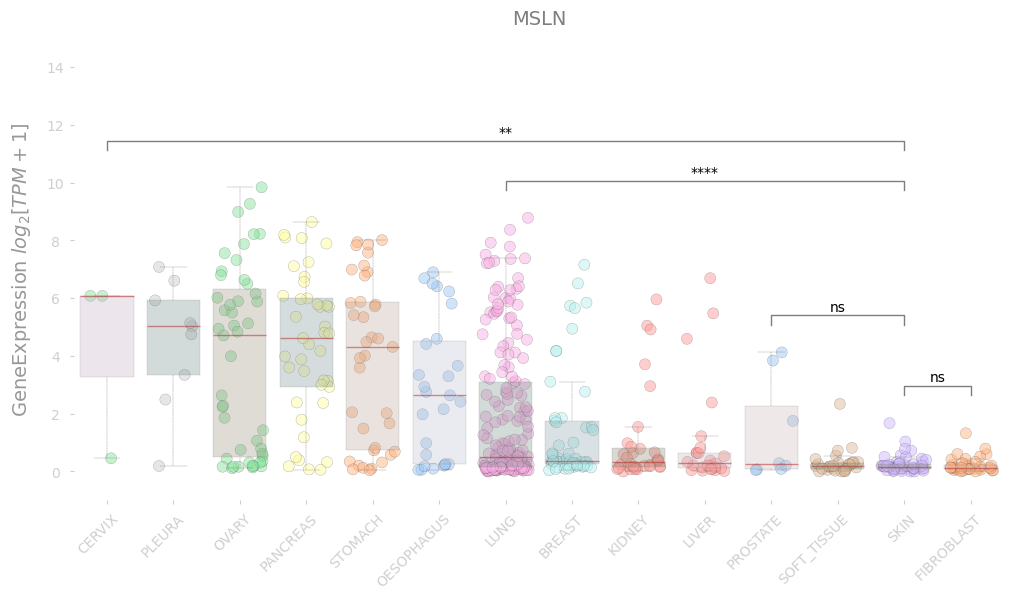

RAB5A 3.1842802944193824


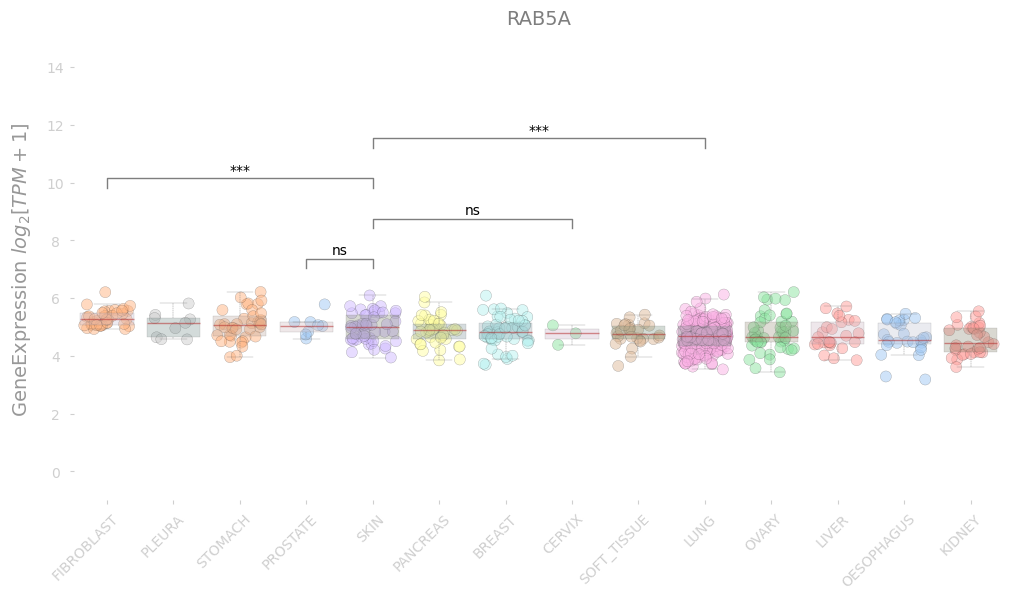

RAB5B 2.790772037862


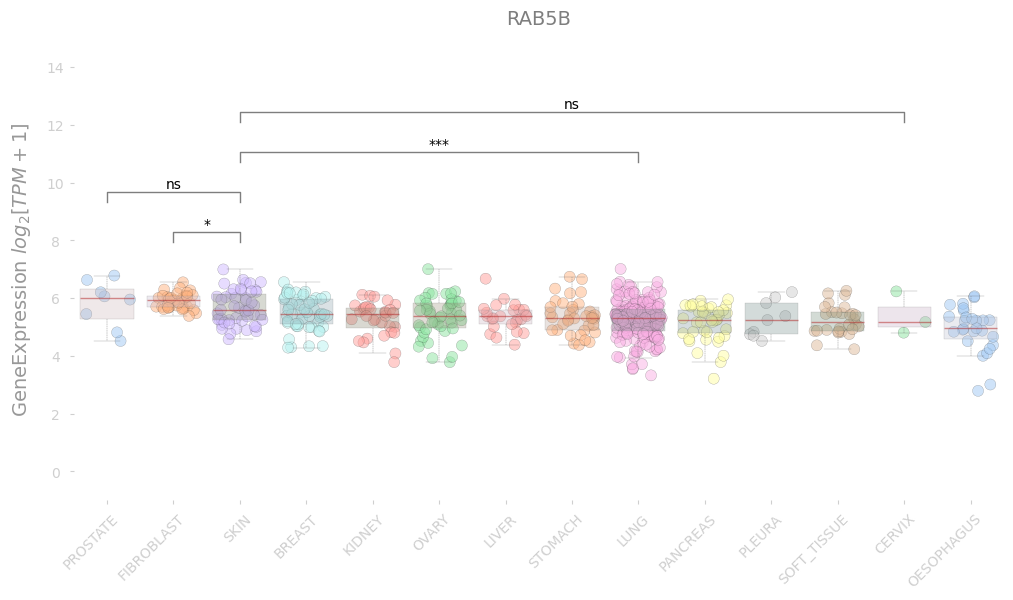

ERBB3 0.12432813500220177


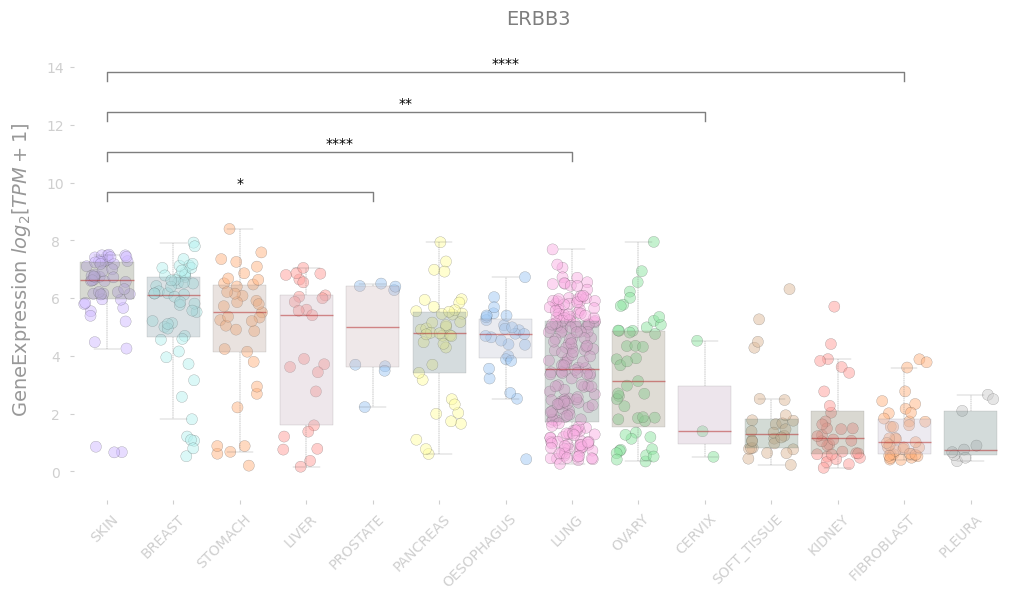

ERBB2 0.49569516262406876


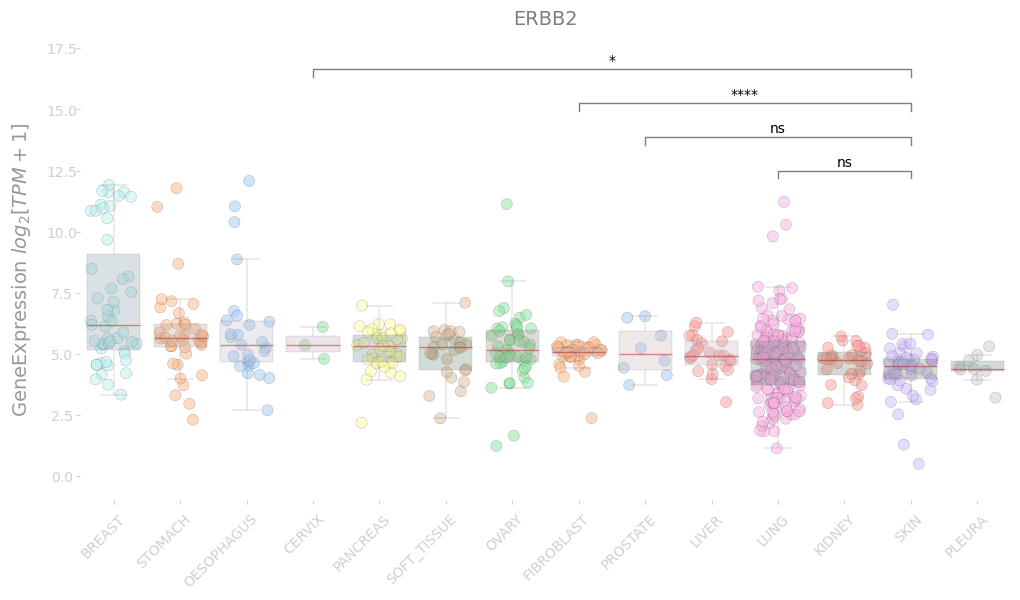

CTLA4 0.0


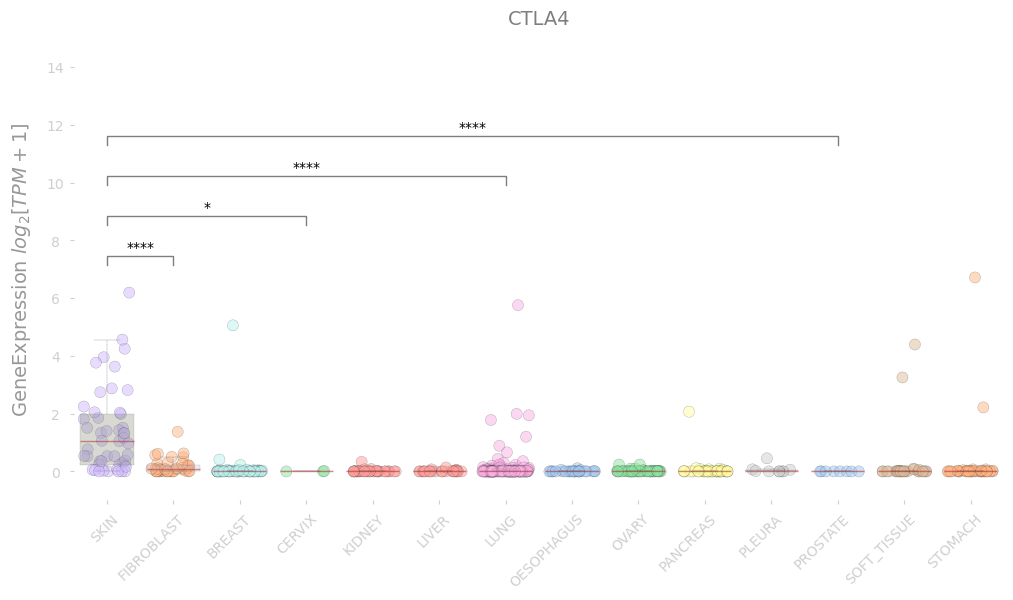

CPU times: total: 34.8 s
Wall time: 35.1 s


In [28]:
%%time
for gene in GenesOfInterest:
    fig, ax = plt.subplots(figsize=(12, 6)); plt.subplots_adjust(wspace=0.02, hspace=0.01)
    sns.plotting_context("notebook", font_scale = 2)
    #        -         -        -        -         -        -         -        -        -         -        -        -         -    
    data = df2[df2['GeneSymbol'] == gene]; min_value = print(gene, data['GeneExpression'].min())
    data.dropna(subset=['GeneSymbol'], inplace=True); #print(data.head())
    #        -         -        -        -         -        -         -        -        -         -        -        -         -
    median_df = data.groupby(['Tissue'])['GeneExpression'].median().sort_values(ascending=False).reset_index()
    order = median_df.Tissue.tolist(); # print(order)
    #        -         -        -        -         -        -         -        -        -         -        -        -         -
    data=data; x="Tissue"; y ="GeneExpression"; hue='Tissue'
    #        -         -        -        -         -        -         -        -        -         -        -        -         -
    str_kws = {'s':8, 'jitter':.35, 'alpha':0.5, 'dodge':False, 'linewidth':0.2,'edgecolor':'#1E1E1E','palette':palette, 'order':order, 'hue':hue}
    box_kws = {'linewidth':0.5, 'width':0.80, 'dodge':False, 'showcaps':True, 'whis':1.5, 'fliersize':0, 'saturation':0.20, 'order':order}
    mprops=dict(linestyle='-', linewidth=1, color="firebrick", alpha=0.5); cprops=dict(linestyle="-", alpha=.5, linewidth=.3);
    bprops=dict(linestyle="-", alpha=.3, linewidth=.3); wprops=dict(linestyle="--", linewidth=.3, color="#7E7E7E");
    #        -         -        -        -         -        -         -        -        -         -        -        -         -   
    plt.gca().set_yscale('linear'); plt.ylim(-3, 15) 
    g = sns.boxplot(data=data, x=x, y=y, hue=hue, medianprops=mprops, capprops=cprops, boxprops=bprops, whiskerprops=wprops, **box_kws, zorder=1, ax=ax)
    g = sns.stripplot(data=data, x=x, y=y, zorder=0, **str_kws, ax=ax)  
    #        -         -        -        -         -        -         -        -        -         -        -        -         -   
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1)
    #        -         -        -        -         -        -         -        -        -         -        -        -         - 
    ax.set_title(gene, fontsize=14, color="#7E7E7E", pad=10)
    axlabelkws = {'fontsize':14, 'color':'#7E7E7E', 'alpha':0.8, 'labelpad':10}
    #plt.xlabel(""); plt.ylabel("log2[TPM+1]", **axlabelkws); # (Reads Per Kilobase of transcript)
    plt.xlabel(""); plt.ylabel(r"GeneExpression $log_{2}[TPM+1]$", **axlabelkws)
    #        -         -        -        -         -        -         -        -        -         -        -        -         - 
    plt.gca().set_yscale('linear'); plt.ylim(-1, 15); sns.despine(left=True, bottom=True)     
    #        -         -        -        -         -        -         -        -        -         -        -        -         - 
    plt.xticks(fontsize=10, color="#7E7E7E", rotation=45, ha="right")
    ax.tick_params(axis='x', which='major', pad=10, length=3, colors="#cfcfcf")
    plt.yticks(fontsize=10, color="#7E7E7E", rotation=0, ha="center")
    ax.tick_params(axis='y', which='major', pad=10, length=3, colors="#cfcfcf")
    #        -         -        -        -         -        -         -        -        -         -        -        -         - 
    dx, dy = 10/72., 5/72.; offset = mtransforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    #        -         -        -        -         -        -         -        -        -         -        -        -         -              
    annot_kws1 = {'pairs':pairs, 'data':data, 'x':x, 'y':y, 'order':order}
    annot_params = {"test":"Mann-Whitney", "line_width":1, "color":"#7E7E7E", "text_format":"star", 'loc':'inside'}
    try:
        ax, test_results = Annotator(ax, **annot_kws1).reset_configuration().configure(**annot_params, verbose=0).apply_and_annotate()
    except Exception as e:
        print(f"An unexpected error occurred with {gene}: {e}")
        textkws = {'weight':500, 'va':'center', 'alpha':1, 'rotation':35,}; axs = ax.transAxes
        bboxkws = {'facecolor':'white', 'edgecolor':'#FF0000', 'linewidth': 5, 'boxstyle':'round','pad':10}
        ax.text(0.5, 0.5, 'NO DATA', fontsize=70, ha='center', color='#FF0000', transform=axs, bbox=bboxkws, **textkws)
    #          -          -          -          -          -          -          -          -          -          -          - 
    plt.legend([],[],frameon=False)
    #plt.tight_layout()
    plt.show()

In [29]:
print("'CPTAC_FragPipe_DEG_Cluster_v02' script run time:", f'{time.time()-start:.0f}', "seconds.")

'CPTAC_FragPipe_DEG_Cluster_v02' script run time: 126 seconds.
